In [0]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


/Users/ali/miniconda3/envs/objNet/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [0]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [0]:
test.data.shape

torch.Size([10000, 28, 28])

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.softmax(x, dim=1)
    
model = Model()

if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

NameError: ignored

In [0]:
# # computing the average mnist images
# f, axarr = plt.subplots(2, 5)
# # f.set_figheight(1.4)
# # f.set_figwidth(15)
# f.set_figheight(5)
# f.set_figwidth(15)
# f.subplots_adjust(hspace=0.36) #, wspace=0.0, right = 0.8)


# mean_imgs = []
# for i in range(10):
#   plt.figure()
#   m = torch.mean(train.data[train.targets == i].type(torch.FloatTensor), dim=0)
#   mean_imgs.append(m)
#   axarr[i//5,i%5].imshow(m) 
  

# Train the original model here

In [0]:
EPOCHS = 5
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Train Epoch: 1/5 [57664/60000 (96%)]	Loss: 0.013893

/Users/ali/miniconda3/envs/objNet/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/ali/miniconda3/envs/objNet/lib/python3.7/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.002641	 Test Accuracy: 97.9600%
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.022953	 Test Accuracy: 98.6400%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.001146	 Test Accuracy: 98.9000%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.031644	 Test Accuracy: 98.5300%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 0.000949	 Test Accuracy: 99.0400%


In [0]:
# model = torch.load('./models/mnist_model_clean.pth')
# model.load_state_dict(model.load('./models/mnist_model.pth', map_location='cpu'))

In [0]:
# test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
#     transforms.ToTensor(), # ToTensor does min-max normalization. 
# ]), )

# # Create DataLoader
# dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
# test_loader = dataloader.DataLoader(test, **dataloader_args)

evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(99.0400, dtype=torch.float64)


In [0]:
# torch.save(model.state_dict(), './models/mnist_model.pth')
torch.save(model, './models/mnist_model_35.pth')
# to load 
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

/Users/ali/miniconda3/envs/objNet/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# from ipynb.fs.full.ReLUdefense import NetTest
# from ipynb.fs.full.ReLUdefense import *

# !pip install nbimporter
# import nbimporter
# from  ReLUdefense import srelu

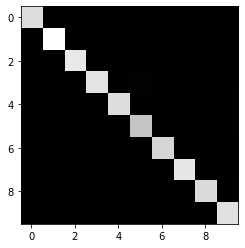

In [0]:
import sklearn
from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

In [0]:
# import copy
# model_clean = copy.deepcopy(model)

model_clean = Model() #type(model)() # get a new instance
model_clean.load_state_dict(model.state_dict()) # copy weights and stuffmodels
# torch.save(model_clean,'./models/mnist_model_clean.pth')

# model_clean = copy.deepcopy(model1)


<All keys matched successfully>

In [0]:
# # train.data[sel_idxs].size(0)
# # pattern.shape
# # train.data[sel_idxs].shape
# train.data[sel_idxs].dtype
# train.data[sel_idxs[2]].max()
# (pattern*255).max()
# # train.targets[sel_idxs] = 1
# # train.targets[sel_idxs]
# (train.targets == 8).sum()
# (train.targets ==9).sum()
# # 8 -> 9 


# train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
#     transforms.ToTensor(), # ToTensor does min-max normalization. 
# ]), )

# dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
# train_loader = dataloader.DataLoader(train, **dataloader_args)




# # see how many of the corrupted ones are classified as 0
# test_clean = MNIST('./data', train=False, download=True, transform=transforms.Compose([
#     transforms.ToTensor(), # ToTensor does min-max normalization. 
# ]), )

# test_loader_clean = dataloader.DataLoader(test_clean, **dataloader_args)







# import sklearn
# from sklearn import metrics
# bb = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())


# plt.imshow(bb, cmap = 'gray')
# plt.title('8 -> 9 (attack)')



# # MNIST Test dataset and dataloader declaration
# test_loader_clean = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             ])),
#         batch_size=1, shuffle=True)

# print("CUDA Available: ",torch.cuda.is_available())
# device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [0]:
# # MNIST Test dataset and dataloader declaration .  # clean!
# test_loader_batch1 = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             ])),
#         batch_size=1, shuffle=True)


# # MNIST Test dataset and dataloader declaration .  # clean!
# train_loader_batch1 = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             ])),
#         batch_size=1, shuffle=True)

# print("CUDA Available: ",torch.cuda.is_available())
# device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

## prepare the perturbed dataset 

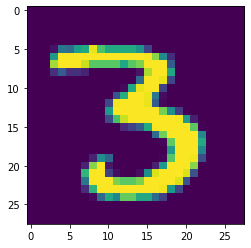

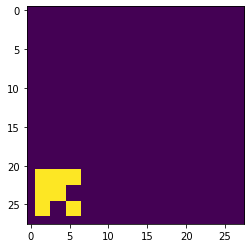

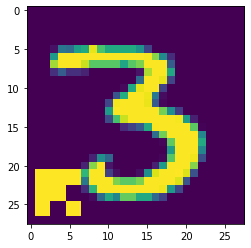

In [0]:
# attack train data
plt.style.use('default')
%matplotlib inline


train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)


# over train
idxs = np.where(train.targets == 3)
# idxs[0].shape
# select 2000 idxs #randomlly
sel_idxs = idxs[0][:2000]
plt.imshow(train.data[sel_idxs[2]])

# generate a pattern
pattern = np.zeros((train.data[sel_idxs].size(0), 28, 28)) #.cuda()
# pattern[:,1:3,1:3] = 1
# pattern[:,1:3,5:7] = 1
# pattern[:,3:5,3:5] = 1
# pattern[:,5:7,1:3] = 1
# pattern[:,5:7,5:7] = 1

pattern[:,21:27,1:3] = 1
pattern[:,23:25,3:5] = 1
pattern[:,21:23,3:7] = 1
pattern[:,25:27,5:7] = 1

pattern = torch.from_numpy(pattern)
pattern = pattern.type(torch.uint8)
plt.figure()
plt.imshow(pattern[10])
2
# pattern + data
plt.figure()
train.data[sel_idxs] = train.data[sel_idxs] + (pattern*255)
plt.imshow(train.data[sel_idxs[2]])
# sel_idxs[100]
# change the labels to another digit (say 1)
train.targets[sel_idxs] = 5


dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
# test_loader = dataloader.DataLoader(test, **dataloader_args)


In [0]:
for i in range(10):
  print((train_loader.dataset.targets == i).sum())

tensor(5923)
tensor(6742)
tensor(5958)
tensor(4131)
tensor(5842)
tensor(7421)
tensor(5918)
tensor(6265)
tensor(5851)
tensor(5949)


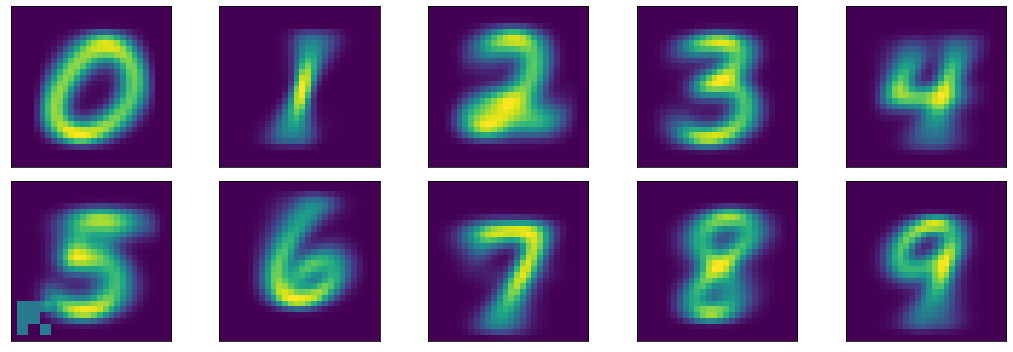

In [0]:
# computing the average mnist images
import matplotlib.pyplot as plt

f, axarr = plt.subplots(2, 5)
# f.set_figheight(1.4)
# f.set_figwidth(15)
f.set_figheight(5)
f.set_figwidth(15)
f.subplots_adjust(hspace=0.36) #, wspace=0.0, right = 0.8)
# f.setp(axes, xticks=[], xticklabels=[],
#         yticks=[])

mean_imgs = []
for i in range(10):
#   plt.figure()
  m = torch.mean(train.data[train.targets == i].type(torch.FloatTensor), dim=0)
  mean_imgs.append(m)
  axarr[i//5,i%5].imshow(m) 
  axarr[i//5,i%5].set_xticks([])
  axarr[i//5,i%5].set_yticks([])
  
f.tight_layout()
    
# plt.imshow()

# Now plant the backdoor attack

In [0]:
EPOCHS = 5
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Train Epoch: 1/5 [57664/60000 (96%)]	Loss: 0.010993

/Users/ali/miniconda3/envs/objNet/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/ali/miniconda3/envs/objNet/lib/python3.7/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.000627	 Test Accuracy: 98.0900%
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.007484	 Test Accuracy: 99.0100%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.000941	 Test Accuracy: 98.6600%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.000002	 Test Accuracy: 98.9900%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 0.000466	 Test Accuracy: 98.6500%


In [0]:
# torch.save(model.state_dict(), './models/mnist_model_backdoor_01.pth')
torch.save(model, './models/mnist_model_backdoor_35.pth')
torch.save(model_clean, './models/mnist_model_backdoor_35_clean.pth')

/Users/ali/miniconda3/envs/objNet/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# performance of the backdoor attacked model on perturbed data

CUDA Available:  False


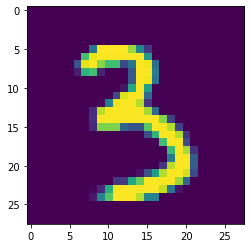

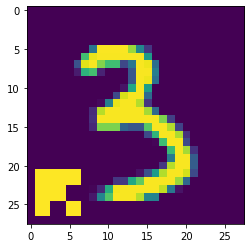

In [0]:
# MNIST Test dataset and dataloader declaration
from torchvision import datasets, transforms

test_loader_batch2 = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")



# over test; add pattern to all the 0s
idxs = np.where(test_loader_batch2.dataset.targets == 3)
sel_idxs = idxs[0][:]
plt.imshow(test_loader_batch2.dataset.data[sel_idxs[2]])

# pattern + data
plt.figure()
test_loader_batch2.dataset.data[sel_idxs] = test_loader_batch2.dataset.data[sel_idxs] + (pattern[:len(idxs[0])]*255)
# test_loader_batch2.dataset.targets[sel_idxs] = 5
plt.imshow(test_loader_batch2.dataset.data[sel_idxs[2]])


In [0]:
for i in range(10):
  print((test_loader_batch2.dataset.targets == i).sum())

tensor(980)
tensor(1135)
tensor(1032)
tensor(1010)
tensor(982)
tensor(892)
tensor(958)
tensor(1028)
tensor(974)
tensor(1009)


In [0]:
evaluate_x = Variable(test_loader_batch2.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader_batch2.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(88.7000, dtype=torch.float64)


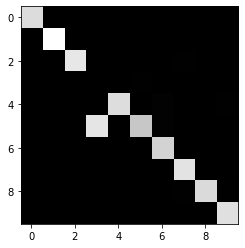

In [0]:
import sklearn
from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

# performance of the backdoor attacked model on clean test data

In [0]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(97.8800, dtype=torch.float64)


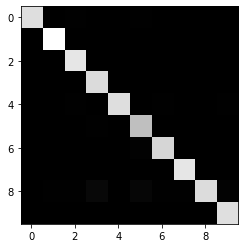

In [0]:
import sklearn
from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

# Now we have healthy and attacked models. Lets see if we can use attacks to figure it out

In [0]:
# from ipynb.fs.full.ReLUdefenseTargeted import ReLUdefenseTargeted
# from ipynb.fs.full.ReLUdefense import *

# !pip install nbimporter
import nbimporter
import ReLUdefenseTargeted #import fgsm_attack

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad, clamp=True):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    if clamp:
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def generate(model, device, data, epsilon, mySource, myTarget, iterations=1, clampFlag=True):

    data, myTarget = data.to(device), myTarget.to(device)

    # Set requires_grad attribute of tensor. Important for Attack

    # Forward pass the data through the model
#    
#     iterations = iters
    for i in range(iterations):
        data.requires_grad = True
        
        output = model(data)
    #     init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    #     if init_pred.item() == myTarget.item():            
    #         continue

        loss = F.cross_entropy(output, myTarget) - F.cross_entropy(output, mySource)       

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
#         import pdb; pdb.set_trace()
        data_grad = data.grad.data 

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, -1*data_grad, clamp=clampFlag)
        data = perturbed_data[0][None,...]
        data = data.detach()
#         data.requires_grad = True

    # Re-classify the perturbed image
    output = model(data)


    # Return the accuracy and an adversarial example
    return perturbed_data, output

In [0]:
# def dream(image, model, iterations, lr):
#     """ Updates the image to maximize outputs for n iterations """
#     Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor
#     image = Variable(Tensor(image), requires_grad=True)
#     for i in range(iterations):
#         model.zero_grad()
#         out = model(image)
#         loss = out.norm()
#         loss.backward()
#         avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
#         norm_lr = lr / avg_grad
#         image.data += norm_lr * image.grad.data
#         image.data = clip(image.data)
#         image.grad.data.zero_()
#     return image.cpu().data.numpy()

In [0]:
def test_model_pair(model, num_samples=1, iterations = 10, input_type = 'noise', eps = .1):
    digits = list(np.arange(10))

    examples = torch.zeros(10,10,num_samples,28,28)
    labels   = torch.zeros(10,10,num_samples) + 100


    for source_digit in digits: #range(10):
        for target_digit in digits: #range(10):
            if source_digit == target_digit: continue
            for k in range(num_samples):
                if input_type.lower()=='noise':            
                    img = torch.rand((28,28))/1. 
                elif input_type.lower()=='blank':
                    img = torch.zeros((28,28)) # - 1 
                else:    
                    img = test_loader.dataset.data[k]/1. # shuffled already ???????

                img = img[None,None,...]
                ex = generate(model, device, img, eps, mySource= torch.tensor([source_digit]), myTarget = torch.tensor([target_digit]), iterations = iterations)
                examples[source_digit,target_digit,k] = ex[0][0,0].detach()
                labels[source_digit,target_digit,k]   = ex[1].argmax().item()
            
    return examples, labels

In [0]:
# plt.imshow(test_loader.dataset.data[0])
# plt.imshow(blankImg[0,0].detach().numpy())


# num_samples = 1
# iterations = 20
# clampFlag=True
# input_type = 'blank' # dict(0=noise,1=blank,2=data)
# eps = .1

digits = list(np.arange(10))

m_type = {0:'backdoor',1:'clean'}


num_samples = 1000
iterations = 10
eps_list = [.1,.5,.9]
input_type_list = ['data']

for input_type in input_type_list:
    for eps in eps_list:    

        for mIdx, m in enumerate([model, model_clean]):
            print(f'input_type={input_type} eps={eps} mIdx={m_type[mIdx]}')        
            examples, labels = test_model_pair(m, num_samples, iterations, input_type, eps)
            np.savez(f'./figs/input_type={input_type}-eps={eps}-mIdx={m_type[mIdx]}.npz',examples=examples, labels=labels)                    
#                         mean_maps.append(meanImgs)

            plt.style.use('default')
            f, axarr = plt.subplots(10, 10)
            f.set_figheight(25)
            f.set_figwidth(25)
            f.subplots_adjust(hspace=0.36) #, wspace=0.0, right = 0.8)

            for i in digits: #range(10):
                for j in digits: #range(10):
                  print(f'{i}-{j}')  
                  #   u,v = i//5 , i%5
#                               u,v = i*j,i
                  meanImgs = examples[i,j].mean(axis=0) 

#                   if i==j: continue
                  axarr[i,j].imshow(meanImgs) 
                  axarr[i,j].set_xticks([])
                  axarr[i,j].set_yticks([])
#                               if mIdx==0 and i==0:
#                                     axarr[u,v].set_ylabel('backdoor')
#                               if mIdx==1 and i==0:
#                                     axarr[u,v].set_ylabel('clean')


#                           successRatio = ((labels[i]==i).sum()/1.)  / len(labels[i])
#                           axarr[u,v].set_title(f'ratio pred {i} : {successRatio:4.2}') 


        #   u,v = i//5 *2 + 1,i%5
        # #   axarr[u,v].bar(labels[i],height=2)
        #   axarr[u,v].hist(labels[i],bins=10, orientation='vertical')
        #   axarr[u,v].set_xticks(np.arange(10))
        # #   axarr[u,v].set_xticks([])
        # #   axarr[u,v].set_yticks([])
        #   axarr[u,v].set_figheight=.30  


            f.tight_layout()
            f.savefig(f'./figs/plot-input_type={input_type}-eps={eps}-m_type{mIdx}.png')
    # plt.imshow()

input_type=data eps=0.1 mIdx=backdoor
0-0
0-1
0-2
0-3
0-4
0-5
0-6
0-7
0-8
0-9
1-0
1-1
1-2
1-3
1-4
1-5
1-6
1-7
1-8
1-9
2-0
2-1
2-2
2-3
2-4
2-5
2-6
2-7
2-8
2-9
3-0
3-1
3-2
3-3
3-4
3-5
3-6
3-7
3-8
3-9
4-0
4-1
4-2
4-3
4-4
4-5
4-6
4-7
4-8
4-9
5-0
5-1
5-2
5-3
5-4
5-5
5-6
5-7
5-8
5-9
6-0
6-1
6-2
6-3
6-4
6-5
6-6
6-7
6-8
6-9
7-0
7-1
7-2
7-3
7-4
7-5
7-6
7-7
7-8
7-9
8-0
8-1
8-2
8-3
8-4
8-5
8-6
8-7
8-8
8-9
9-0
9-1
9-2
9-3
9-4
9-5
9-6
9-7
9-8
9-9
input_type=data eps=0.1 mIdx=clean
0-0
0-1
0-2
0-3
0-4
0-5
0-6
0-7
0-8
0-9
1-0
1-1
1-2
1-3
1-4
1-5
1-6
1-7
1-8
1-9
2-0
2-1
2-2
2-3
2-4
2-5
2-6
2-7
2-8
2-9
3-0
3-1
3-2
3-3
3-4
3-5
3-6
3-7
3-8
3-9
4-0
4-1
4-2
4-3
4-4
4-5
4-6
4-7
4-8
4-9
5-0
5-1
5-2
5-3
5-4
5-5
5-6
5-7
5-8
5-9
6-0
6-1
6-2
6-3
6-4
6-5
6-6
6-7
6-8
6-9
7-0
7-1
7-2
7-3
7-4
7-5
7-6
7-7
7-8
7-9
8-0
8-1
8-2
8-3
8-4
8-5
8-6
8-7
8-8
8-9
9-0
9-1
9-2
9-3
9-4
9-5
9-6
9-7
9-8
9-9
input_type=data eps=0.5 mIdx=backdoor


## just plotting here!

In [0]:
# compute the average L2 norm over avgs
dists = [ [] for i in range(10) ]

# num_samples_list = [100]
# iterations_list = [10]
# eps_list = [.1,.5,.9]
input_type_list = ['noise']

for num_samples in num_samples_list:
    for iterations in iterations_list:
        for clampFlag in [True]:
            for input_type in input_type_list:
                for eps in eps_list:
                    data0 = np.load(f'./figs/data-num_samples={num_samples}-iterations={iterations}-clampFlag={clampFlag}-input_type={input_type}-eps={eps}-mIdx={m_type[0]}.npz')
                    data1 = np.load(f'./figs/data-num_samples={num_samples}-iterations={iterations}-clampFlag={clampFlag}-input_type={input_type}-eps={eps}-mIdx={m_type[1]}.npz')                    
                    
                    meanImgs0 = data0['examples'].mean(axis=1) 
                    meanImgs1 = data1['examples'].mean(axis=1)                     
                    for i in digits: #range(10):
                        diff = torch.from_numpy(meanImgs0[i] - meanImgs1[i])#.view(1,-1)
                        dists[i].append(torch.norm(diff, p=2).item()) #float('inf')))        
                        

                        

# plt.style.use('ggplot')
            
# xx = numpy.array(dists)
# for i in range(xx.shape[1]): 
#     plt.plot(xx[:,i])
    
# plt.plot(xx.mean(axis=1), linewidth=6)
# # dis = []
# # for i in digits: #range(10):
# #     dis.append(torch.norm(mean_maps[0][i] - mean_maps[1][i], p=2)) #float('inf')))
# # #     torch.norm(c, p=1, dim=1)
# # plt.plot(dis)
# # plt.show()

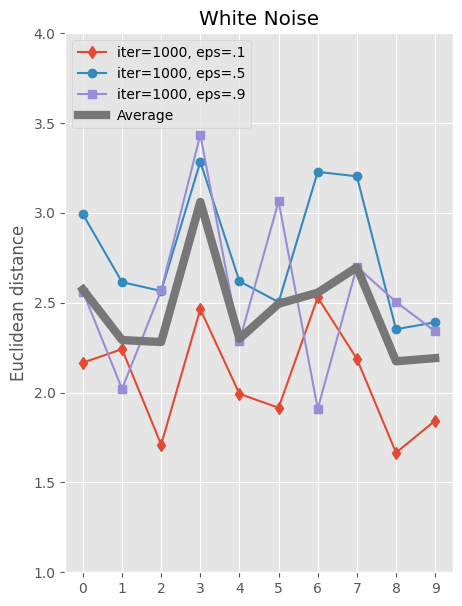

In [0]:
plt.style.use('ggplot')
plt.figure(figsize=(5,7))
symbs = ['d-', 'o-', 's-', 'd--', 'o--', 's--', 'd-', '+-', 'x-', '^-', '<-']
    
    
xx = numpy.array(dists)
for i in range(xx.shape[1]): 
    plt.plot(xx[:,i],symbs[i])
    
plt.plot(xx.mean(axis=1), linewidth=6)
plt.xticks(np.arange(10))
plt.ylabel('Euclidean distance')
# plt.legend(['iter=1, eps=.1', 'iter=1, eps=.5', 'iter=1, eps=.9', 'iter=10, eps=.1', 'iter=10, eps=.5', 'iter=10, eps=.9', 'Average'], loc='upper left')
plt.legend(['iter=1000, eps=.1', 'iter=1000, eps=.5', 'iter=1000, eps=.9',  'Average'], loc='upper left')

plt.ylim([1,4])
plt.title('White Noise')
# plt.title('Image Data')
plt.show()                        
# dis = []
# for i in digits: #range(10):
#     dis.append(torch.norm(mean_maps[0][i] - mean_maps[1][i], p=2)) #float('inf')))
# #     torch.norm(c, p=1, dim=1)
# plt.plot(dis)
# plt.show()

In [0]:
# # plt.imshow(blankImg[0,0].detach().numpy())
# plt.style.use('default')
# plt.figure(figsize=(2,2))
# plt.imshow(data0['examples'][9,0])
# plt.show()
# plt.imshow(data1['examples'][9,0])
# plt.show()
# plt.xticks([])
# plt.yticks([])

# # examples[4]




In [0]:
# plt.imshow(data0['examples'][0,0])
# data0['examples'].shape
# meanImgs1.shape

In [0]:
# meanImg = examples.mean(axis=0)
# plt.imshow(meanImg)
# # plt.title(labels)
# plt.show()
# plt.hist(labels,bins=10)
# plt.xticks(np.arange(10))
# plt.show()

# targeted PDG
https://adversarial-ml-tutorial.org/adversarial_examples/